# Projeto

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [3]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


## PCA

### 2 Features

In [4]:
data_frame_fcnc_pca = data_frame_fcnc.copy()
data_frame_bkg_pca = data_frame_bkg.copy()

# Drop the categorical features except label, weights and gen_split
data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

# Drop the features that are not in both dataframes
for feature in data_frame_fcnc_pca.columns.values:
    if feature not in data_frame_bkg_pca.columns.values:
        data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

for feature in data_frame_bkg_pca.columns.values:
    if feature not in data_frame_fcnc_pca.columns.values:
        data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
# Join the dataframes
data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

# Substitute the labels "signal" and "bkg" by 1 and 0
data = data.replace(['signal'], 1)
data= data.replace(['bkg'], 0)

# train, test and validation sets
train = data.loc[data['gen_split'] == 'train']
test = data.loc[data['gen_split'] == 'test']
val = data.loc[data['gen_split'] == 'val']


In [5]:
print(data.columns.values)

['Electron_Multi' 'FatJet1_Eta' 'FatJet1_Mass' 'FatJet1_PT' 'FatJet1_Phi'
 'FatJet1_Tau1' 'FatJet1_Tau2' 'FatJet1_Tau3' 'FatJet1_Tau4'
 'FatJet1_Tau5' 'FatJet_Multi' 'Jet1_BTag' 'Jet1_Eta' 'Jet1_Mass'
 'Jet1_PT' 'Jet1_Phi' 'Jet2_BTag' 'Jet2_Eta' 'Jet2_Mass' 'Jet2_PT'
 'Jet2_Phi' 'Jet3_BTag' 'Jet3_Eta' 'Jet3_Mass' 'Jet3_PT' 'Jet3_Phi'
 'Jet4_BTag' 'Jet4_Eta' 'Jet4_Mass' 'Jet4_PT' 'Jet4_Phi' 'Jet5_BTag'
 'Jet5_Eta' 'Jet5_Mass' 'Jet5_PT' 'Jet5_Phi' 'Jet_Multi' 'Lepton1_Eta'
 'Lepton1_PT' 'Lepton1_Phi' 'Lepton2_Eta' 'Lepton2_PT' 'Lepton2_Phi'
 'MissingET_MET' 'MissingET_Phi' 'Muon_Multi' 'ScalarHT_HT' 'gen_label'
 'gen_split' 'gen_weights' 'gen_xsec']


In [6]:
# which data will be used for fitting the PCA.
# Everything except the weights, name and label
DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
pca_n_features = 2

def perform_PCA (DataFeatures, pca_n_features, train, data):

    ## Fit PCA to train data & rank components by AUC
    pca = PCA(n_components=len(DataFeatures))
    pca.fit(train[DataFeatures])

    ## Transform the desired dataset to get its principal components
    # Get ranked components by AUC from the train data
    principalComponents = pca.transform(train[DataFeatures])

    # Book will be a dictiorary with the AUC (values) of each component (keys)
    book = {}

    # Get values for AUC computation
    y_true = train['gen_label'].values
    weights = train["gen_xsec"].values

    # Renormalise weights
    weights[y_true == 1] = (weights[y_true == 1] / weights[y_true == 1].sum()) * weights.shape[0] / 2
    weights[y_true == 0] = (weights[y_true == 0] / weights[y_true == 0].sum()) * weights.shape[0] / 2

    for feature_idx in range(principalComponents.shape[1]):
        book[f"Component {feature_idx}"] = roc_auc_score(y_true=y_true, y_score=principalComponents[:, feature_idx], sample_weight=weights)

    # Give me the best features
    book = pd.DataFrame.from_dict(book, orient="index")
    book.columns = ["AUC"]
    book.sort_values(by="AUC", ascending=False, inplace=True)
    book.reset_index(inplace=True)
    book.rename(columns={"index": "Feature"}, inplace=True)

    ## Replace current data by its components ##
    # Get components for the current set we want
    principalComponents = pca.transform(data[DataFeatures])

    # Create a new dataframe with PCA data
    newdf = pd.DataFrame(principalComponents, columns=[f"Component {i}" for i in range(principalComponents.shape[1])])

    # Select the best components given their AUC performance in training data
    newdf = newdf[book["Feature"][0 : pca_n_features]]

    # Add the other relevant features
    newdf["gen_xsec"] = data["gen_xsec"].values
    newdf["gen_label"] = data["gen_label"].values
    newdf["gen_split"] = data["gen_split"].values

    # Finally, replace self.data with newdf
    data = newdf

    # Update DataFeatures
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
    
    return data, DataFeatures, book


In [7]:
### perform PCA on the train data
data, DataFeatures, book = perform_PCA (DataFeatures, pca_n_features, train, data)

In [8]:
print (book)

         Feature       AUC
0    Component 1  0.775146
1    Component 3  0.715941
2    Component 0  0.687727
3   Component 14  0.630145
4   Component 36  0.605685
5   Component 41  0.596724
6    Component 6  0.570540
7    Component 4  0.556490
8   Component 38  0.537973
9   Component 45  0.534386
10   Component 7  0.516444
11  Component 20  0.507134
12  Component 31  0.504426
13  Component 24  0.504415
14  Component 17  0.504408
15  Component 32  0.503685
16  Component 37  0.503436
17  Component 23  0.503101
18  Component 21  0.502556
19  Component 22  0.502165
20  Component 28  0.501944
21  Component 19  0.501000
22  Component 39  0.499701
23   Component 8  0.499632
24  Component 34  0.499389
25  Component 26  0.499241
26  Component 18  0.497846
27  Component 16  0.497146
28  Component 25  0.497129
29  Component 35  0.495980
30  Component 29  0.495669
31  Component 33  0.492140
32  Component 42  0.485668
33  Component 15  0.484882
34  Component 30  0.483164
35  Component 44  0.480199
3

In [9]:
print (data)

         Component 1  Component 3  gen_xsec  gen_label gen_split
0         223.756164    79.522846  0.001285          1      test
1          59.754944   -85.367973  0.001285          1       val
2          81.103303   -23.975222  0.001285          1     train
3         135.995448   -19.004199  0.001285          1     train
4         332.762183    96.144389  0.001285          1     train
...              ...          ...       ...        ...       ...
1093033   -85.532615   -23.609642  3.181214          0      test
1093034   -11.067453   186.076860  3.181214          0     train
1093035   107.619697   217.027728  3.181214          0     train
1093036   177.072743   -23.538135  3.181214          0       val
1093037    21.303249   238.575669  3.181214          0     train

[1093038 rows x 5 columns]


#### SVMs

In [10]:
#normalize the data except the categorical features and the weights
data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()

# divide the new data into train, test and validation sets
train = data.loc[data['gen_split'] == 'train']
test = data.loc[data['gen_split'] == 'test']
val = data.loc[data['gen_split'] == 'val']

# divide the train data into signal and background and get 500 samples of each
train_sgn = train.loc[train['gen_label'] == 1].sample(n=500, random_state=42)
train_bkg = train.loc[train['gen_label'] == 0].sample(n=500, random_state=42)
x_train = pd.concat([train_sgn, train_bkg])
x_train = x_train.sample(frac=1, random_state=42)

# divide the validation data into signal and background and get 500 samples of each
val_sgn = val.loc[val['gen_label'] == 1].sample(n=500, random_state=42)
val_bkg = val.loc[val['gen_label'] == 0].sample(n=500, random_state=42)
x_val = pd.concat([val_sgn, val_bkg])
x_val = x_val.sample(frac=1, random_state=42)

# divide the test data into signal and background and get 500 samples of each
test_sgn = test.loc[test['gen_label'] == 1].sample(n=500, random_state=42)
test_bkg = test.loc[test['gen_label'] == 0].sample(n=500, random_state=42)
x_test = pd.concat([test_sgn, test_bkg])
x_test = x_test.sample(frac=1,random_state=42)

# get an array with the labels for each set
y_train = x_train['gen_label'].values
y_val = x_val['gen_label'].values
y_test = x_test['gen_label'].values

# get an array with the weights for each set
w_train = x_train["gen_xsec"].values
w_val = x_val["gen_xsec"].values
w_test = x_test["gen_xsec"].values

# get an array with the features for each set
x_train = x_train[DataFeatures].values
x_val = x_val[DataFeatures].values
x_test = x_test[DataFeatures].values


##### Train

In [11]:
# Renormalize weights
w_train[y_train == 1] = (w_train[y_train == 1] / w_train[y_train == 1].sum()) * w_train.shape[0] / 2
w_train[y_train == 0] = (w_train[y_train == 0] / w_train[y_train == 0].sum()) * w_train.shape[0] / 2

# Train SMV
clf = svm.SVC(kernel="rbf", probability=True)   
clf.fit(x_train, y_train,sample_weight=w_train)


SVC(probability=True)

##### Validation

In [12]:
# Renormalize weights
w_val[y_val == 1] = (w_val[y_val == 1] / w_val[y_val == 1].sum()) * w_val.shape[0] / 2
w_val[y_val == 0] = (w_val[y_val == 0] / w_val[y_val == 0].sum()) * w_val.shape[0] / 2

# Predict
y_val_scores = clf.predict_proba(x_val)
y_val_scores = y_val_scores[:, 1]
y_val_pred = clf.predict(x_val)

# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred,sample_weight=w_val)
auc_score = roc_auc_score(y_val, y_val_scores,sample_weight=w_val)

print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.6952914738500099
ROC AUC Score: 0.7614569725181437


##### Test

In [13]:

# Renormalize weights
w_test[y_test == 1] = (w_test[y_test == 1] / w_test[y_test == 1].sum()) * w_test.shape[0] / 2
w_test[y_test == 0] = (w_test[y_test == 0] / w_test[y_test == 0].sum()) * w_test.shape[0] / 2

# Predict
y_test_scores = clf.predict_proba(x_test)
y_test_scores = y_test_scores[:, 1]
y_pred = clf.predict(x_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
auc_score = roc_auc_score(y_test, y_test_scores, sample_weight=w_test)
print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.7744352718425372
ROC AUC Score: 0.8383333087700772


/tmp/ipykernel_994872/1217247063.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


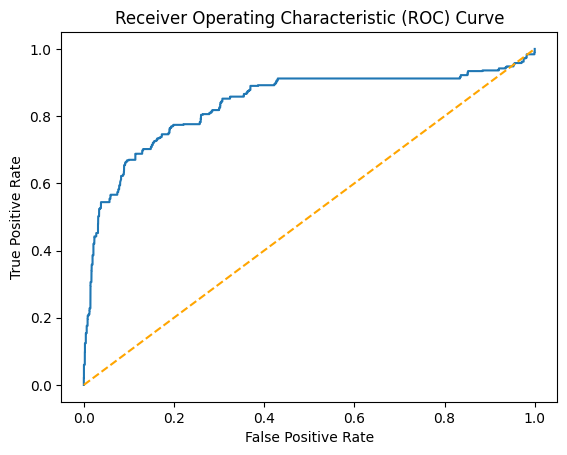

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores, sample_weight=w_test)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

[1.00041576e+01 2.98562795e+01 2.45087305e+02 3.76992785e+01
 2.73049497e+01 2.01834029e+01 2.98229636e+01 5.07336798e+00
 1.33544826e+01 5.17380220e+00 1.90657967e+01 1.05868501e+01
 2.33174116e+00 3.14426759e+00 3.13886621e+00 8.50522661e+00
 1.06250562e+01 2.04529023e+00 1.04338839e+00 2.28593693e-01
 1.94197755e+00 2.16988590e+00 9.72207439e-01 2.01014139e+00
 1.21626853e+00 1.30366253e-01 2.98481671e+00 2.06594094e+00
 1.11044296e+00 1.12288576e+00]
[  0.608663    11.71823259   4.22793507 196.62213528  22.09351022
  10.3026184    9.99626579   9.74264233   8.38735578  16.5684747
   4.99943356   3.22360339   3.88425457   8.59009991   4.15759237
   7.75400201  17.25470145  16.07806892  12.82941771   9.48507023
   8.78410473   2.73673577   3.49822425   1.82214001  10.74127128
   4.67145217  23.00447639   5.38145155  45.70010291  15.13596369]


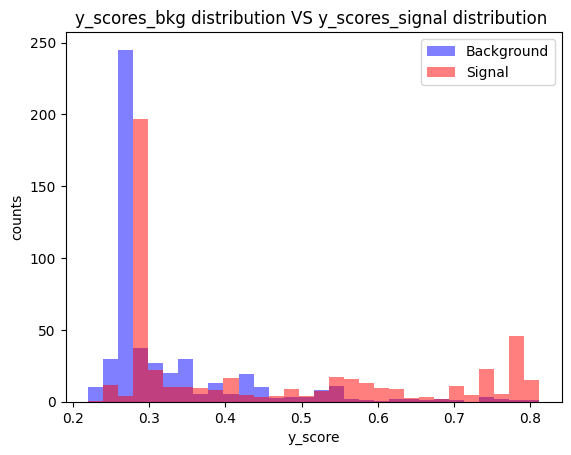

In [15]:
# Plot signal and background distributions for the predicted scores with normalized counts and log scale

num_bins = 30  # Number of bins

# Compute the range for the bins based on the minimum and maximum values of the data
min_value = min(min(y_test_scores[y_test == 0]), min(y_test_scores[y_test == 1]))
max_value = max(max(y_test_scores[y_test == 0]), max(y_test_scores[y_test == 1]))
bin_range = (min_value, max_value)

counts, bins, _ = plt.hist(y_test_scores[y_test == 0], bins=num_bins, range=bin_range,  weights=w_test[y_test==0], alpha=0.5, color='b', label='Background')
counts2, bins2, _ = plt.hist(y_test_scores[y_test == 1], bins=num_bins, range=bin_range,weights=w_test[y_test==0], alpha=0.5, color='r', label='Signal')

print(counts)
print(counts2)

plt.xlabel('y_score')
plt.ylabel('counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

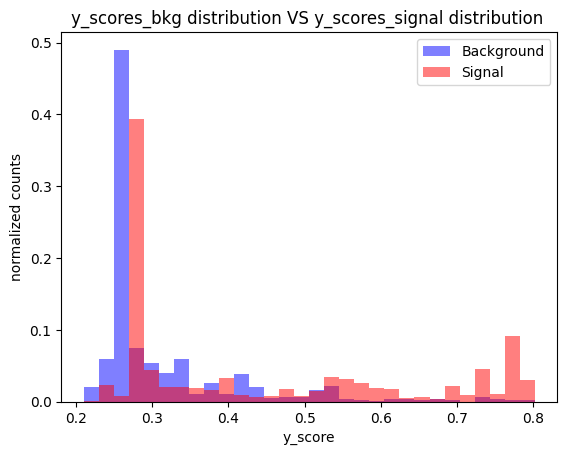

In [16]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

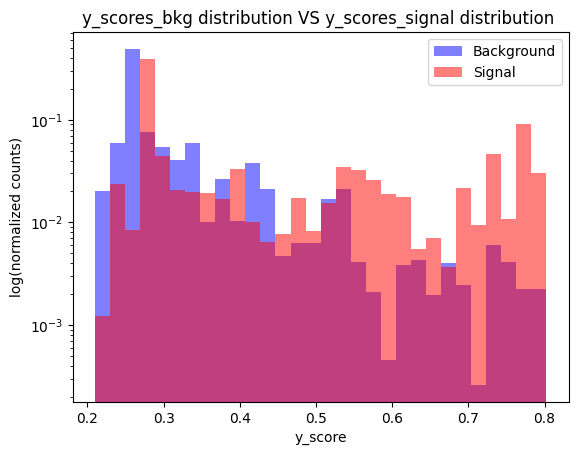

In [17]:
# Normalize the counts
counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('log(normalized counts)')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.yscale('log')
plt.legend()
plt.show()

### All features

In [18]:
data_frame_fcnc_pca = data_frame_fcnc.copy()
data_frame_bkg_pca = data_frame_bkg.copy()

# Drop the categorical features except label, weights and gen_split
data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

# Drop the features that are not in both dataframes
for feature in data_frame_fcnc_pca.columns.values:
    if feature not in data_frame_bkg_pca.columns.values:
        data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

for feature in data_frame_bkg_pca.columns.values:
    if feature not in data_frame_fcnc_pca.columns.values:
        data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
# Join the dataframes
data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

# Substitute the labels "signal" and "bkg" by 1 and 0
data = data.replace(['signal'], 1)
data= data.replace(['bkg'], 0)

# train, test and validation sets
train = data.loc[data['gen_split'] == 'train']
test = data.loc[data['gen_split'] == 'test']
val = data.loc[data['gen_split'] == 'val']

In [19]:
### perform PCA on the train data
DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
pca_n_features = len(DataFeatures)
data, DataFeatures, book = perform_PCA (DataFeatures, pca_n_features, train, data)

#### SVM: PCA

In [20]:
#normalize the data except the categorical features and the weights
data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()

# divide the new data into train, test and validation sets
train = data.loc[data['gen_split'] == 'train']
test = data.loc[data['gen_split'] == 'test']
val = data.loc[data['gen_split'] == 'val']

# divide the train data into signal and background and get 500 samples of each
train_sgn = train.loc[train['gen_label'] == 1].sample(n=500,random_state=42)
train_bkg = train.loc[train['gen_label'] == 0].sample(n=500,random_state=42)
x_train = pd.concat([train_sgn, train_bkg])
x_train = x_train.sample(frac=1,random_state=42)

# divide the validation data into signal and background and get 500 samples of each
val_sgn = val.loc[val['gen_label'] == 1].sample(n=500,random_state=42)
val_bkg = val.loc[val['gen_label'] == 0].sample(n=500,random_state=42)
x_val = pd.concat([val_sgn, val_bkg])
x_val = x_val.sample(frac=1,random_state=42)

# divide the test data into signal and background and get 500 samples of each
test_sgn = test.loc[test['gen_label'] == 1].sample(n=500,random_state=42)
test_bkg = test.loc[test['gen_label'] == 0].sample(n=500,random_state=42)
x_test = pd.concat([test_sgn, test_bkg])
x_test = x_test.sample(frac=1,random_state=42)

# get an array with the labels for each set
y_train = x_train['gen_label'].values
y_val = x_val['gen_label'].values
y_test = x_test['gen_label'].values

# get an array with the weights for each set
w_train = x_train["gen_xsec"].values
w_val = x_val["gen_xsec"].values
w_test = x_test["gen_xsec"].values

# get an array with the features for each set
x_train = x_train[DataFeatures].values
x_val = x_val[DataFeatures].values
x_test = x_test[DataFeatures].values

In [21]:
print (test_sgn)

       Component 1  Component 3  Component 0  Component 14  Component 36  \
66255     0.826078     1.309718    -1.076582      2.894919      0.254444   
8525     -0.120551    -1.276881     0.958675      0.804814     -1.906699   
40769     1.553261     0.007239     0.643861     -0.199368     -0.246911   
82779     1.076660     1.562491    -0.601509     -0.322264     -0.529110   
1786      0.720303     0.886022    -0.646121      0.191515     -0.778542   
...            ...          ...          ...           ...           ...   
78767     0.706074     0.248458     1.108802      1.338054      0.737141   
30348     0.081264    -0.973303     1.137886     -1.038397     -0.989767   
27620    -0.269972    -0.006718    -0.305430     -0.792646      0.227933   
82368    -0.777682     0.455836    -0.642360      1.343430      0.457187   
37585     1.200604     1.473057    -0.440259      0.463439     -0.913350   

       Component 41  Component 6  Component 4  Component 38  Component 45  \
66255     

##### Train

In [22]:
# Renormalize weights
w_train[y_train == 1] = (w_train[y_train == 1] / w_train[y_train == 1].sum()) * w_train.shape[0] / 2
w_train[y_train == 0] = (w_train[y_train == 0] / w_train[y_train == 0].sum()) * w_train.shape[0] / 2

# Train SMV
clf = svm.SVC(kernel="rbf", probability=True)   
clf.fit(x_train, y_train,sample_weight=w_train)

SVC(probability=True)

##### Validation

In [23]:
# Renormalize weights
w_val[y_val == 1] = (w_val[y_val == 1] / w_val[y_val == 1].sum()) * w_val.shape[0] / 2
w_val[y_val == 0] = (w_val[y_val == 0] / w_val[y_val == 0].sum()) * w_val.shape[0] / 2

# Predict
y_val_scores = clf.predict_proba(x_val)
y_val_scores = y_val_scores[:, 1]
y_val_pred = clf.predict(x_val)

# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred,sample_weight=w_val)
auc_score = roc_auc_score(y_val, y_val_scores,sample_weight=w_val)

print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.8814342508428229
ROC AUC Score: 0.9618536829930573


##### Test

In [24]:
# Renormalize weights
w_test[y_test == 1] = (w_test[y_test == 1] / w_test[y_test == 1].sum()) * w_test.shape[0] / 2
w_test[y_test == 0] = (w_test[y_test == 0] / w_test[y_test == 0].sum()) * w_test.shape[0] / 2

# Predict
y_test_scores = clf.predict_proba(x_test)
y_test_scores = y_test_scores[:, 1]
y_pred = clf.predict(x_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
auc_score = roc_auc_score(y_test, y_test_scores, sample_weight=w_test)
print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.7160577575061181
ROC AUC Score: 0.8822861069761733


/tmp/ipykernel_994872/1217247063.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


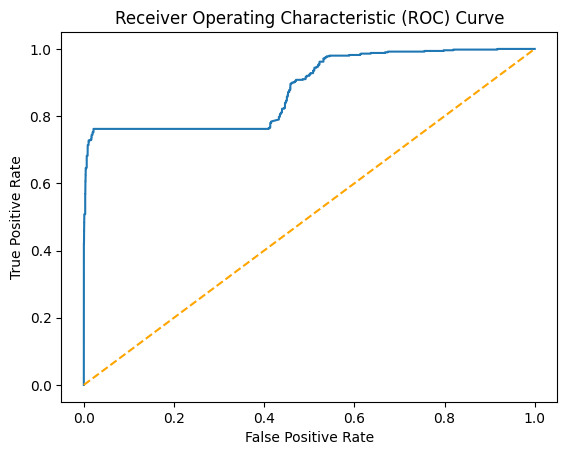

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores, sample_weight=w_test)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

[1.05151228e+02 6.91645265e+01 3.13195224e+01 2.82981696e+01
 5.66421225e+00 4.74568023e+00 3.29480684e+00 6.47964716e+00
 1.17199666e+01 5.04765748e+00 1.33898359e+00 1.63473381e+00
 3.13904623e+00 3.36427624e+00 3.33793051e+00 9.56656007e+00
 1.97131390e+02 2.28688344e+00 2.99476912e+00 1.08645151e+00
 2.18702653e-02 1.32288391e+00 3.48261644e-01 9.90541922e-01
 1.24889307e-01 3.58583253e-01 2.91522571e-02 8.47904624e-03
 2.88966678e-02 0.00000000e+00]
[1.60771791e-02 2.26103303e-01 2.36753119e-02 3.94588532e-02
 3.13147060e+00 1.10467238e+00 1.20344904e+00 3.03745260e+00
 8.28458524e+00 2.82165589e+00 1.02944105e+01 1.05159505e+01
 1.15108213e+01 2.02926288e+02 1.34890795e+01 8.71527057e+00
 1.05635769e+01 7.56219675e+00 7.85521600e+00 3.47338200e+00
 1.43093635e+00 4.52524182e+00 1.17979578e+01 3.63938027e+01
 1.81390038e+01 1.89080762e+01 3.48257327e+01 2.61609611e+01
 3.19420239e+01 9.08147107e+00]


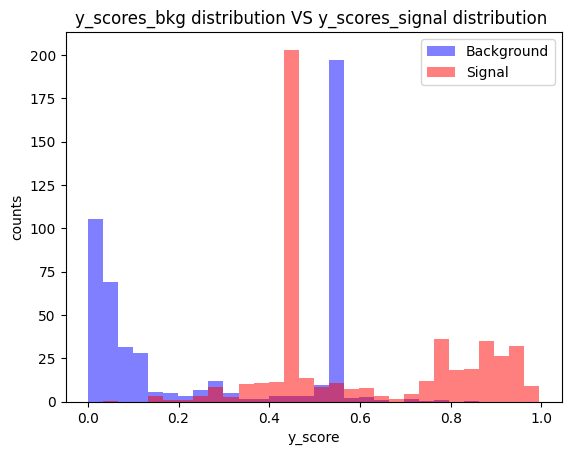

In [26]:
# Plot signal and background distributions for the predicted scores with normalized counts and log scale

num_bins = 30  # Number of bins

# Compute the range for the bins based on the minimum and maximum values of the data
min_value = min(min(y_test_scores[y_test == 0]), min(y_test_scores[y_test == 1]))
max_value = max(max(y_test_scores[y_test == 0]), max(y_test_scores[y_test == 1]))
bin_range = (min_value, max_value)

counts, bins, _ = plt.hist(y_test_scores[y_test == 0], bins=num_bins, range=bin_range,  weights=w_test[y_test==0], alpha=0.5, color='b', label='Background')
counts2, bins2, _ = plt.hist(y_test_scores[y_test == 1], bins=num_bins, range=bin_range,weights=w_test[y_test==0], alpha=0.5, color='r', label='Signal')

print(counts)
print(counts2)

plt.xlabel('y_score')
plt.ylabel('counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

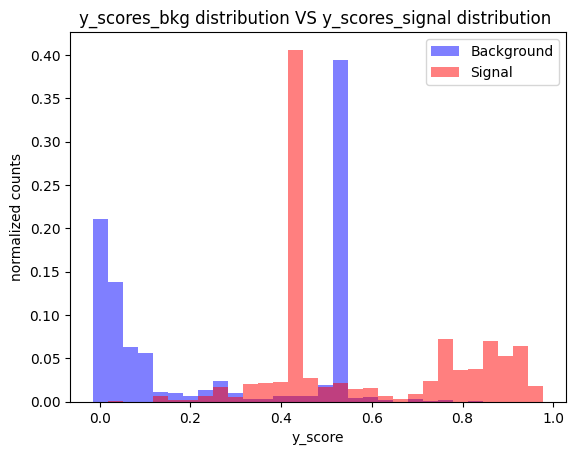

In [27]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

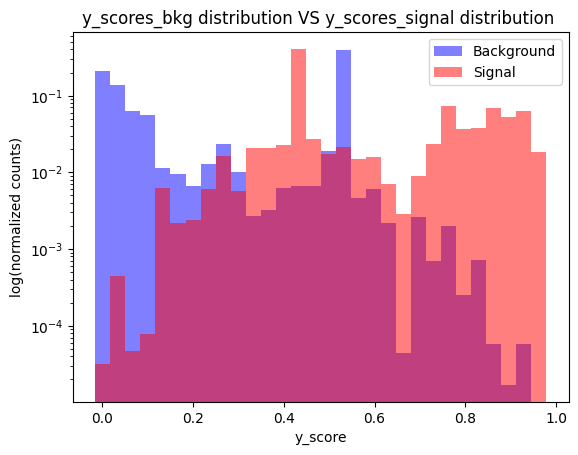

In [28]:
# Normalize the counts
counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('log(normalized counts)')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.yscale('log')
plt.legend()
plt.show()

#### SVM: Sem PCA

In [29]:
data_frame_fcnc_pca = data_frame_fcnc.copy()
data_frame_bkg_pca = data_frame_bkg.copy()

# Drop the categorical features except label, weights and gen_split
data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

# Drop the features that are not in both dataframes
for feature in data_frame_fcnc_pca.columns.values:
    if feature not in data_frame_bkg_pca.columns.values:
        data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

for feature in data_frame_bkg_pca.columns.values:
    if feature not in data_frame_fcnc_pca.columns.values:
        data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
# Join the dataframes
data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

# Substitute the labels "signal" and "bkg" by 1 and 0
data = data.replace(['signal'], 1)
data= data.replace(['bkg'], 0)

#normalize the data except the categorical features and the weights
DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()

# train, test and validation sets
train = data.loc[data['gen_split'] == 'train']
test = data.loc[data['gen_split'] == 'test']
val = data.loc[data['gen_split'] == 'val']

# divide the train data into signal and background and get 500 samples of each
train_sgn = train.loc[train['gen_label'] == 1].sample(n=500,random_state=42)
train_bkg = train.loc[train['gen_label'] == 0].sample(n=500,random_state=42)
x_train = pd.concat([train_sgn, train_bkg])
x_train = x_train.sample(frac=1,random_state=42)

# divide the validation data into signal and background and get 250 samples of each
val_sgn = val.loc[val['gen_label'] == 1].sample(n=500,random_state=42)
val_bkg = val.loc[val['gen_label'] == 0].sample(n=500,random_state=42)
x_val = pd.concat([val_sgn, val_bkg])
x_val = x_val.sample(frac=1,random_state=42)

# divide the test data into signal and background and get 250 samples of each
test_sgn = test.loc[test['gen_label'] == 1].sample(n=500,random_state=42)
test_bkg = test.loc[test['gen_label'] == 0].sample(n=500,random_state=42)
x_test = pd.concat([test_sgn, test_bkg])
x_test = x_test.sample(frac=1,random_state=42)

# get an array with the labels for each set
y_train = x_train['gen_label'].values
y_val = x_val['gen_label'].values
y_test = x_test['gen_label'].values

# get an array with the weights for each set
w_train = x_train["gen_xsec"].values
w_val = x_val["gen_xsec"].values
w_test = x_test["gen_xsec"].values

# get an array with the features for each set
x_train = x_train[DataFeatures].values
x_val = x_val[DataFeatures].values
x_test = x_test[DataFeatures].values

In [30]:
print (test_sgn)

       Electron_Multi  FatJet1_Eta  FatJet1_Mass  FatJet1_PT  FatJet1_Phi  \
66255        0.190846    -0.206387      0.729573   -0.506333    -0.938517   
8525         1.252431    -0.099555      0.579566    0.053786    -0.089638   
40769        1.252431    -0.787784      0.353797    0.867813     0.827167   
82779       -0.870738    -2.001008      0.764936   -0.048181    -1.323773   
1786        -0.870738     0.195689     -0.512045   -0.639714     1.216680   
...               ...          ...           ...         ...          ...   
78767       -0.870738    -0.023877     -0.638208    1.195555    -0.789228   
30348       -0.870738     0.895927      1.693466    0.060342    -1.585507   
27620       -0.870738     0.178134      0.859158   -0.821966    -0.776027   
82368       -0.870738     1.026208     -0.988336   -0.929137    -0.686383   
37585        1.252431     0.812625      0.494854    0.327273    -0.631532   

       FatJet1_Tau1  FatJet1_Tau2  FatJet1_Tau3  FatJet1_Tau4  FatJet1_Tau5

##### Train

In [31]:
# Renormalize weights
w_train[y_train == 1] = (w_train[y_train == 1] / w_train[y_train == 1].sum()) * w_train.shape[0] / 2
w_train[y_train == 0] = (w_train[y_train == 0] / w_train[y_train == 0].sum()) * w_train.shape[0] / 2

# Train SMV
clf = svm.SVC(kernel="rbf", probability=True)   
clf.fit(x_train, y_train,sample_weight=w_train)


SVC(probability=True)

##### Validation

In [32]:
# Renormalize weights
w_val[y_val == 1] = (w_val[y_val == 1] / w_val[y_val == 1].sum()) * w_val.shape[0] / 2
w_val[y_val == 0] = (w_val[y_val == 0] / w_val[y_val == 0].sum()) * w_val.shape[0] / 2

# Predict
y_val_scores = clf.predict_proba(x_val)
y_val_scores = y_val_scores[:, 1]
y_val_pred = clf.predict(x_val)

# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred,sample_weight=w_val)
auc_score = roc_auc_score(y_val, y_val_scores,sample_weight=w_val)

print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.8526760213682151
ROC AUC Score: 0.9625338124521068


##### Test

In [33]:

# Renormalize weights
w_test[y_test == 1] = (w_test[y_test == 1] / w_test[y_test == 1].sum()) * w_test.shape[0] / 2
w_test[y_test == 0] = (w_test[y_test == 0] / w_test[y_test == 0].sum()) * w_test.shape[0] / 2

# Predict
y_test_scores = clf.predict_proba(x_test)
y_test_scores = y_test_scores[:, 1]
y_pred = clf.predict(x_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
auc_score = roc_auc_score(y_test, y_test_scores, sample_weight=w_test)
print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.7067920539596853
ROC AUC Score: 0.905406966666251


/tmp/ipykernel_994872/1217247063.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


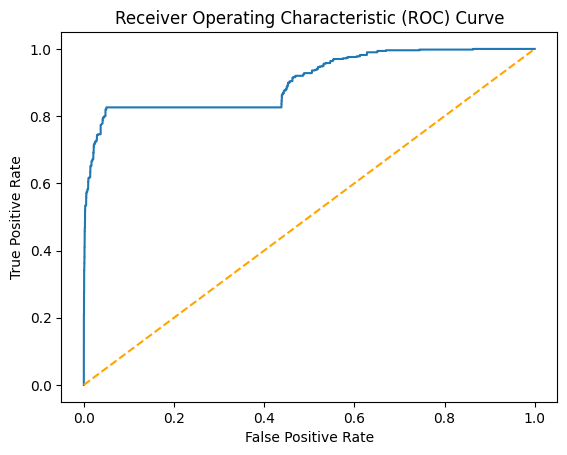

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores, sample_weight=w_test)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

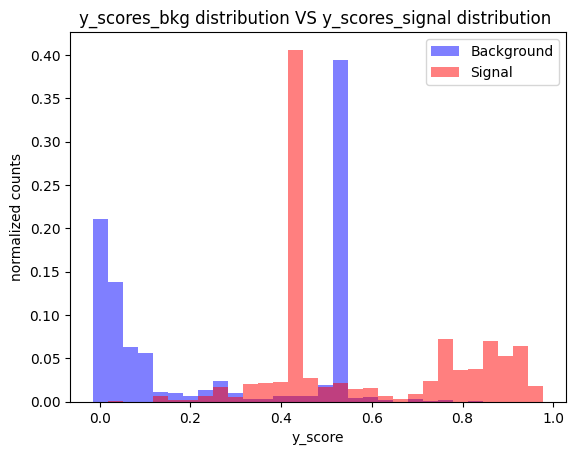

In [35]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

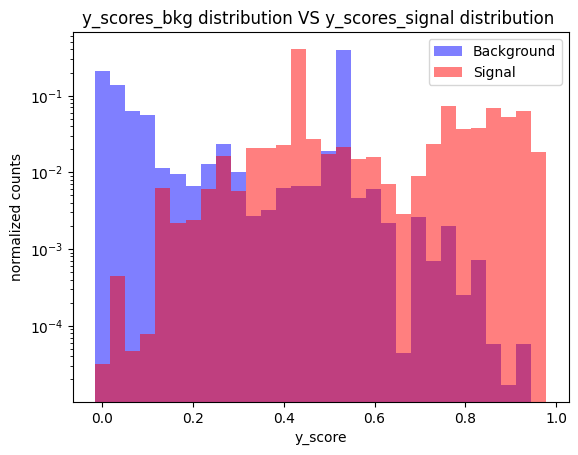

In [36]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.yscale('log')
plt.legend()
plt.show()